useful resource: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

## these modules need to be installed before starting

In [1]:
pip install chart_studio 

     |████████████████████████████████| 64 kB 966 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scattertext

     |████████████████████████████████| 7.2 MB 1.3 MB/s eta 0:00:01    |▎                               | 61 kB 1.0 MB/s eta 0:00:07     |██                              | 430 kB 1.3 MB/s eta 0:00:06
Note: you may need to restart the kernel to use updated packages.


In [4]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 1.3 MB/s eta 0:00:01    |██                              | 778 kB 444 kB/s eta 0:00:26
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.0-py3-none-any.whl size=12048606 sha256=3cce00e837c095091a1463e3f21dc427812a580ddba020441250225c08c933d1
  Stored in directory: /private/var/folders/5x/x59rmh_d4rvbf_d98x0sp00c0000gn/T/pip-ephem-wheel-cache-8ss07tua/wheels/71/4a/56/e48f8ad9359a6780edd8cdd42955519b1a21d6365ad15628a2
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [7]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
import scattertext as st
import spacy
from pprint import pprint
import en_core_web_sm
#nlp = spacy.load('en_core_web_md')
nlp = en_core_web_sm.load()

Loading BokehJS ...

In [3]:
#%cd "gdrive/My Drive/Colab Notebooks"
!ls

20200504-193926_joe_biden_nlp.csv      nlp_EDA.ipynb
20200504-193926_joe_biden_nlp_subs.csv nlp_EDA[Conflict].ipynb
Convention-Visualization.html          nlp_EDA_v2.ipynb
Extract_subtitles.ipynb                nlp_export.pkl
Language_model.ipynb                   nlp_model_training.ipynb
models


In [8]:
# load train_cleaned.csv
filename = "~/Documents/GitHub/esade_fake_news/1_Climate_Change/youtube_query/data/nlp/20200507-033205_climate_change_nlp_subs.csv"
df = pd.read_csv(filename, usecols=['Bias_num', 'subtitles','channel'])
df_channel = df.copy()
df['text'] = df['subtitles']
df.drop(['subtitles','channel'], axis=1, inplace=True)
df['text'] = df['text'].str[2:-2]
df.head()

,Bias_num,text
0,0.0,NaN
1,0.0,[Music] yeah Irish aqua five bucks North North...
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN


In [9]:
#df['text'] = df['title'] + " " + df['description']
#df.drop(['title', 'description'], inplace=True, axis=1)

#drop NAs
df.dropna(inplace=True)

In [10]:
df['Bias_num'].mean()

0.11904761904761904

## Subtitles cleaning

In [11]:
#split channel string to remove each element from subtitles
df_channel['channel'] = df_channel['channel'].replace("(in English)", '', regex=True)
unique_channel = df_channel['channel'].unique()
unique_channel_split = [i.split(' ') for i in unique_channel]
unique_channel_split[0]

['ABC', 'News']

In [12]:
#remove all channels from text
for channel in unique_channel_split:
    for element in channel:
        df['text'].replace(element,
                           '',
                           inplace=True,
                           regex=True)

In [13]:
#values to be replaced
to_replace = ['Music', 'Applause', 'Laughter']

df['text'].replace(to_replace, '', inplace=True, regex=True)  

In [14]:
df['text'].replace('Music', "", inplace=True)

In [15]:
df['text'] = df['text'].apply(lambda x: x.replace('Music', ""))

In [16]:
#drop channel, not needed
#df.drop('channel', inplace=True, axis=1)

In [17]:
#calculate number of characters
df['review_len'] = df['text'].astype(str).apply(len)

#calculate number of words
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

,Bias_num,text,review_len,word_count
1,0.0,[] yeah Irish aqua five bucks North North Kore...,21784,4094
9,0.0,well as we mentioned the Prime Mister will mak...,4409,805
10,0.0,these are Syrian children playg at a derelict ...,1189,206
11,1.0,My name is Pressor Michio Kaku. \xa0I\'m a\npr...,34096,5521
12,0.0,here's a scary thought what if we can't stop c...,7870,1415


(array([48., 43., 20.,  7.,  3.,  1.,  2.,  1.,  0.,  1.]),
 array([  1189. ,  13201.8,  25214.6,  37227.4,  49240.2,  61253. ,
         73265.8,  85278.6,  97291.4, 109304.2, 121317. ]),
 <a list of 10 Patch objects>)

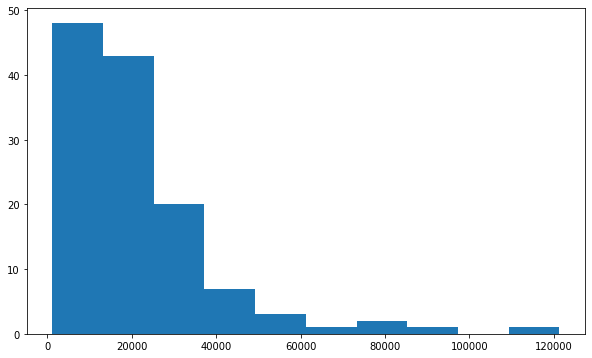

In [18]:
plt.hist(df['review_len'])

(array([53., 37., 21.,  7.,  3.,  1.,  2.,  1.,  0.,  1.]),
 array([  206. ,  2362.9,  4519.8,  6676.7,  8833.6, 10990.5, 13147.4,
        15304.3, 17461.2, 19618.1, 21775. ]),
 <a list of 10 Patch objects>)

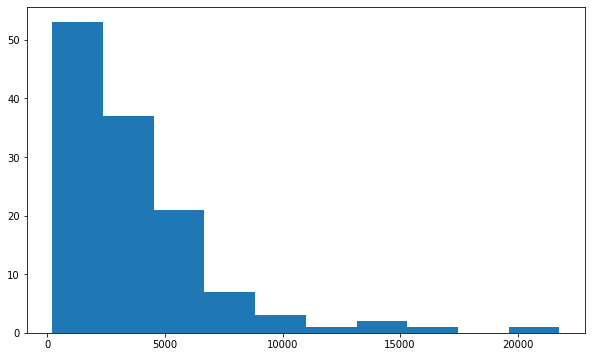

In [19]:
plt.hist(df['word_count'])

In [15]:
x1 = df.loc[df['Bias_num'] == 1, 'word_count']
x0 = df.loc[df['Bias_num'] == 0, 'word_count']

trace1 = go.Histogram(
    x=x0, name='Right',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Left',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of word count based on bias')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [20]:
x1 = df.loc[df['Bias_num'] == 1, 'review_len']
x0 = df.loc[df['Bias_num'] == 0, 'review_len']

trace1 = go.Histogram(
    x=x0, name='Right',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Left',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of review_len based on bias')
fig = go.Figure(data=data, layout=layout)
fig.show()

## The distribution of top unigrams before removing stop words

In [21]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1
df1.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

,text,count
0,the,24784
1,to,15119
2,that,10111
3,it,7928
4,you,7536
5,we,7315
6,is,6765
7,this,4355
8,for,4023
9,have,3722


## The distribution of top unigrams after removing stop words

In [23]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2
df2.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

,text,count
0,people,2029
1,like,1679
2,just,1674
3,know,1484
4,thk,1221
5,gog,1093
6,don,1060
7,ve,1041
8,time,954
9,new,840


## The distribution of top bigrams before removing stop words

In [24]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text'], 20)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df3
df3.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review before removing stop words')


,text,count
0,to the,1280
1,to be,986
2,on the,946
3,we re,942
4,this is,834
5,gog to,715
6,you re,693
7,that we,686
8,you know,683
9,we have,665


## The distribution of top bigrams after removing stop words

In [25]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text'], 20)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df4
df4.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

,text,count
0,don know,199
1,new york,185
2,make sure,144
3,ve got,142
4,united states,133
5,climate change,130
6,years ago,110
7,north korea,106
8,little bit,99
9,don thk,92


## The distribution of Top trigrams before removing stop words

In [26]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['text'], 20)
df5 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df5
df5.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

,text,count
0,we have to,184
1,re gog to,176
2,gog to be,172
3,we need to,162
4,be able to,145
5,you have to,131
6,we re gog,128
7,the united states,120
8,this is the,103
9,to make sure,101


## The distribution of Top trigrams after removing stop words

In [27]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['text'], 20)
df6 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df6
df6.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

,text,count
0,new york city,55
1,want make sure,30
2,health care workers,26
3,new york times,16
4,new silk road,15
5,personal protective equipment,14
6,international space station,13
7,longterm care facilities,13
8,thank madam chair,13
9,david parker ray,13


## Finding characteristic terms and their associations

In [31]:
#convert Bias_num to string
df_corpus = df.copy()
df_corpus['Bias_num'] = df_corpus['Bias_num'].apply(str)
print(df_corpus.dtypes)

Bias_num      object
text          object
review_len     int64
word_count     int64
dtype: object


In [32]:
df_corpus.head()

,Bias_num,text,review_len,word_count
1,0.0,[] yeah Irish aqua five bucks North North Kore...,21784,4094
9,0.0,well as we mentioned the Prime Mister will mak...,4409,805
10,0.0,these are Syrian children playg at a derelict ...,1189,206
11,1.0,My name is Pressor Michio Kaku. \xa0I\'m a\npr...,34096,5521
12,0.0,here's a scary thought what if we can't stop c...,7870,1415


In [33]:
#Following are the terms that differentiate the review text from a general English corpus.
corpus = st.CorpusFromPandas(df_corpus, category_col='Bias_num', text_col='text', nlp=nlp).build()
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['thk', 'gog', 'thgs', 'somethg', 'thg', 'gettg', 'everythg', 'workg', 'chese', 'comg']


In [35]:
#Following are the terms in review text that are most associated with right wing channels:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Right score'] = corpus.get_scaled_f_scores("1.0")
pprint(list(term_freq_df.sort_values(by='Right score', ascending=False).index[:20]))

['governor reagan',
 'carter',
 'reagan',
 'jewel',
 'submersible',
 'silk',
 'coral',
 'silk road',
 'raffles',
 'governor',
 'chese',
 'russia',
 'the chese',
 'recyclg',
 'plastic',
 'president carter',
 'hotel',
 'road',
 'mr',
 'mr .']


In [37]:
#Following are the terms in review text that are most associated with left wing channels:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Left score'] = corpus.get_scaled_f_scores("0.0")
pprint(list(term_freq_df.sort_values(by='Left score', ascending=False).index[:20]))

['tesla',
 'north',
 'and i',
 "i\\'m",
 "we\\'re",
 "you\\'re",
 '♪',
 'and',
 'testg',
 'children',
 'testosterone',
 'money',
 'reporter',
 'diabetes',
 "don\\'t",
 'health',
 '’s',
 "it\\ 's",
 'it\\',
 'car']


In [44]:
html = st.produce_scattertext_explorer(corpus,
                                       category='0.0',
                                       category_name='Left',
                                       not_category_name='Right',
                                       width_in_pixels=1000)

open("Convention-Visualization.html", 'wb').write(html.encode('utf-8'))

4637281

In [45]:
reindexed_data = df['text']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [46]:
n_topics = 5
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [47]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [48]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [49]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [50]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  people like just
Topic 2:  reporter vaccine lumosa
Topic 3:  boeg airles airle
Topic 4:  north korea kim
Topic 5:  space universe earth


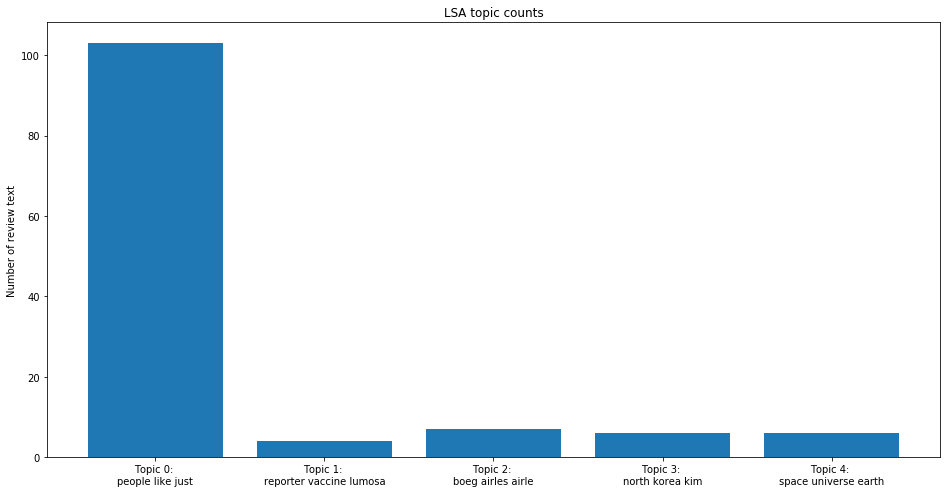

In [51]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

In [52]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 125 nearest neighbors...
[t-SNE] Indexed 126 samples in 0.000s...
[t-SNE] Computed neighbors for 126 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 126 / 126
[t-SNE] Mean sigma: 0.172172
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.809128
[t-SNE] KL divergence after 1050 iterations: 0.203767


In [53]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

In [54]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [55]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

GlyphRenderer(id='1039', ...)